# 1. GENERATION DE DONNEES  

1.1 Base de données en 2D

In [16]:
# Importation des librairies

import pandas as pd
import numpy as np
import math as m
import copy as cp
import sys 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.inspection import DecisionBoundaryDisplay

from matplotlib.legend_handler import HandlerPathCollection

from lime.lime_tabular import LimeTabularExplainer

import shap

In [ ]:
sys.path.append('/Users/garance/Desktop/M2 DAC/XAI/TME/XAI/TME8/DIFFI')

Shape de X:  (500, 2)
Centroides: 
 [[ 1.95254016  8.60757465]
 [ 4.11053504  1.79532732]
 [-3.05380803  5.83576452]
 [-2.49651155 15.67092003]]


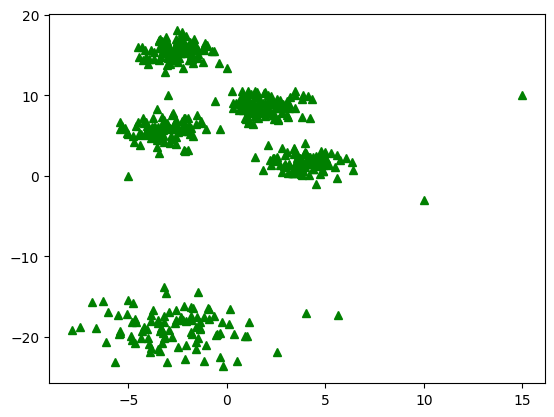

In [2]:
# Génération de données en 2D
X, y, centers = make_blobs(n_samples=400, centers=4, n_features=2, random_state=0, return_centers=True, center_box=(-20.0, 20.0))
X2, y2, centers2 = make_blobs(n_samples=100, centers=1, n_features=2, random_state=2, return_centers=True, center_box=(-20.0, 20.0), cluster_std=2)
X = np.vstack((X, X2))
y = np.zeros(X.shape[0])
print("Shape de X: ", X.shape)
print("Centroides: \n", centers)

# On ajoute des points hors distribution
points = np.array([[15,10], [-5,0], [10,-3], [-3,10]])
X = np.vstack((X, points))
y = np.hstack((y, np.ones(4)))

# Affichage des données
plt.plot(X[:, 0][y==1], X[:, 1][y==1],'g^', )
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'g^')


plt.show()

# 2. MODELES

2.1 Modele One-Class SVM

In [3]:
one_class_SVM = OneClassSVM(gamma='auto').fit(X)
outliers = one_class_SVM.predict(X)
one_class_SVM.score_samples(X)

array([ 3.14552417,  9.23874   ,  8.99584204, 10.18233959,  9.34632251,
       10.21684754, 10.09386847,  9.16170572, 10.10235549, 10.32298738,
       10.3088338 ,  9.72600542,  4.75406227,  9.83184581, 10.12109191,
        7.39113964,  8.30672852, 10.49712434, 10.25587944, 10.50646892,
       10.57839878, 10.32699253, 10.04936912, 10.16304677, 10.41416078,
        9.47746494,  9.91016632,  9.03303864,  9.99352195,  6.31510259,
        8.90803853, 10.04907684, 10.04945858,  9.12579588,  8.06778473,
       10.04955107, 10.05686613, 10.07536793, 10.27485943, 10.25140278,
       10.04931673, 10.27541084, 10.13850017,  6.33116754, 10.44006702,
       10.04917108,  9.75768616, 10.32964444, 10.07584779, 10.30387136,
       10.23037449, 10.02121724,  9.69087474, 10.31196068, 10.28655383,
        7.55775373,  9.7042655 , 10.19776733,  5.93395097,  5.91224481,
       10.20363892,  9.81073434, 10.13184234,  9.19476649, 10.1403024 ,
       10.47017877, 10.11553945,  5.35261221,  7.96272039,  5.47

Les outliers sont les points ayant y = 1

In [4]:
def affichage_list(X, y, classifier):

    # Plot x 
    plt.plot(X[:, 0][y==1], X[:, 1][y==1],'g^', )
    plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], 'bs')
    
    # Frontière décision 
    h = .02  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap='autumn')

    # X contains two features, x1 and x2
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20)

    # Legende
    plt.legend()

    # Displaying the plot.
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


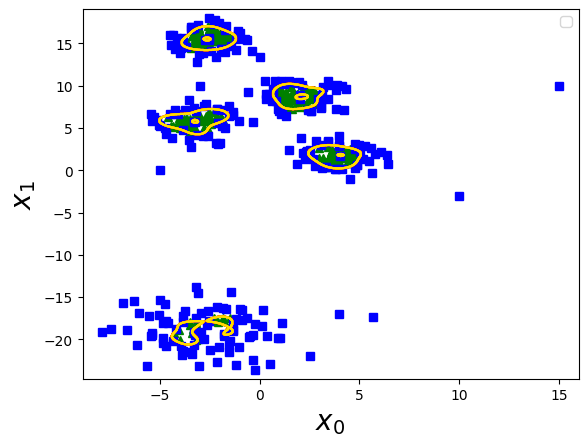

In [5]:
affichage_list(X, outliers, one_class_SVM)

2.2 Modele Isolation Forest

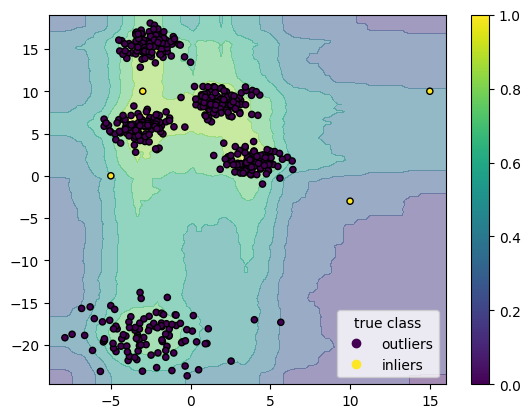

In [6]:
forest = IsolationForest(max_samples=100, random_state=0)
forest.fit(X)

disp = DecisionBoundaryDisplay.from_estimator(
    forest,
    X,
    response_method="decision_function",
    alpha=0.5,
)
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
handles, labels = scatter.legend_elements()
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class", loc="lower right")
plt.colorbar(disp.ax_.collections[1])
plt.show()

2.3 Modele Local Outlier Factor

In [7]:
# Definition du model
LOF = LocalOutlierFactor(n_neighbors=2, novelty=True)
LOF.fit(X)
pred = LOF.predict(X)
pred = -pred # Les outliers sont les points ayant y = -1, pour reutiliser notre fonction on inverse les labels 

Les outliers sont les points ayant y = 1

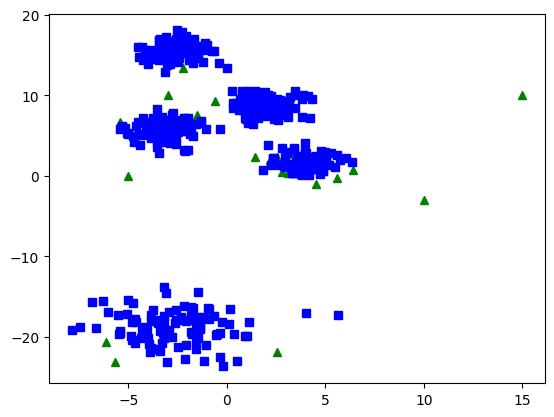

In [8]:
# Affichage
plt.plot(X[:, 0][pred==1], X[:, 1][pred==1],'g^', )
plt.plot(X[:, 0][pred==-1], X[:, 1][pred==-1], 'bs')
plt.show()

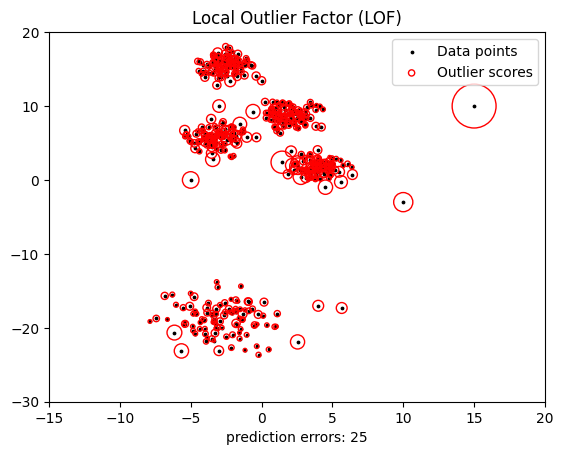

In [9]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])

n_errors = (pred == 1).sum()
X_scores = LOF.negative_outlier_factor_

plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-15, 20))
plt.ylim((-30, 20))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

# 3. EXPLICATION NAIVE  

3.1 Explication naive avec par vecteurs d'importance: LIME

LIME pour regarder quelles sont les features qui ont le plus d'importance


In [10]:
outlier = X[-1]
print(outlier)
feature_names = ['x1', 'x2']
target_names = ['inlier', 'outlier']
model = one_class_SVM

def proba(x):
    p = model.score_samples(X)/max(model.score_samples(X))
    return np.vstack((p,1-p)).reshape(-1,2)

print(proba(X).shape)

explainer_LIME = LimeTabularExplainer(X,
    feature_names=feature_names,
    class_names=target_names,
    mode='classification')

exp = explainer_LIME.explain_instance(outlier, proba, num_features=2)
print(exp.as_list())
exp.as_pyplot_figure()
plt.tight_layout()

[-3. 10.]
(504, 2)


/Users/garance/.pyenv/versions/xai/lib/python3.11/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


ValueError: Found input variables with inconsistent numbers of samples: [5000, 504]

Nous n'avons pas réussi à faire fonctionner LIME avec nos modeles car ces derniers n'ont pas la methode predict_proba. Nous avons essayé d'implémenter une fonction qui remplace predict_proba, qui renvoie exactement (et avec la meme shape) le meme resultat que predict_proba mais nous n'avons pas réussi à faire fonctionner LIME avec cette fonction. 

Nous avons donc décidé d'implémenter la méthode vue lors du TME3 consistant a calculer les vecteurs d'importance nous-meme, puis d'afficher les features les plus importantes dans un barplot. Dans un premier temps nous l'avons fait de maniere globale, puis nous avons décidé de l'appliquer à un exemple particulier.

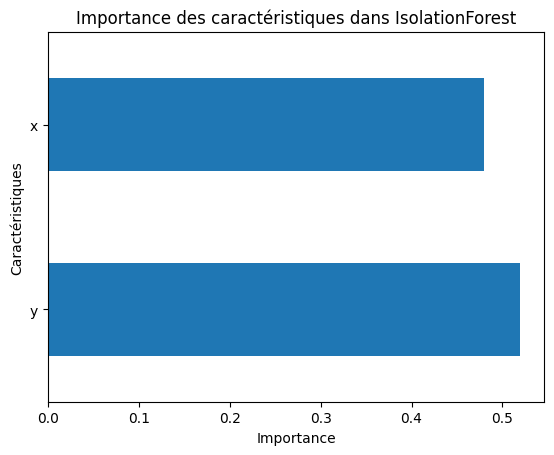

In [12]:
feature_names = ["x", "y"]

# Importance moyenne des caractéristiques 
average_feature_importance = np.mean([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Association importances et caractéristiques
feature_importance_series = pd.Series(average_feature_importance, index=feature_names)

# Affichage
sorted_feature_importance = feature_importance_series.nlargest()
sorted_feature_importance.plot(kind='barh')
plt.title('Importance des caractéristiques dans IsolationForest')
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.show()

In [ ]:
outlier = X[-1]

average_feature_importance = np.mean([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Associer les importances aux noms des caractéristiques
feature_importance_series = pd.Series(average_feature_importance, index=feature_names)

# Trier et afficher les importances des caractéristiques pour l'exemple particulier
sorted_feature_importance = feature_importance_series * outlier
sorted_feature_importance = sorted_feature_importance.nlargest()

# Plot
sorted_feature_importance.plot(kind='barh')
plt.title(f'Importance des caractéristiques pour l\'exemple {outlier} dans IsolationForest')
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.show()

3.2 Growing spheres

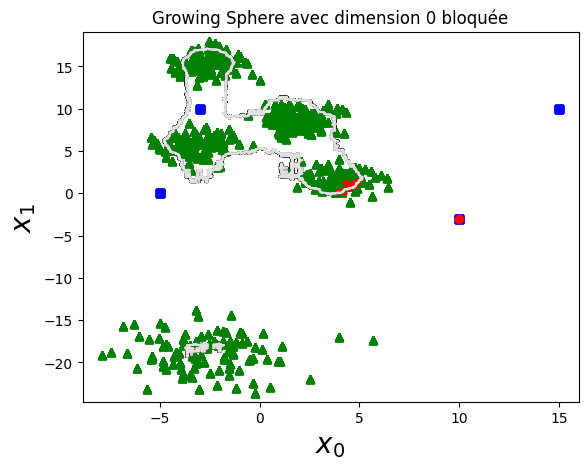

In [21]:
# generation uniforme selon une loi uniforme sur [a0,a1]
def SL(X,a0,a1,n): # fonctionnement mais à verifier
    epsilon = 10**-12
    X= X.reshape(-1)
    d = X.shape[0]
    # distribution gaussienne centrée réduite de taille n*d
    Z1 = np.random.normal(0,1,(n,d))
    #normalisé par la norme de chacun des Zi
    Z2 = Z1 / np.linalg.norm(Z1,axis=1).reshape(-1,1)
    #uniforme sur [a0*d,a1*d]
    u = np.random.uniform(a0*d,a1*d,(n,1))
    u2 = u/(u**d + epsilon)
    #projection sur l'hyperplan et translation
    S = X + Z2*u 
    return S


def algo_GSG(X,classifier,eta,n): 
    d = X.shape[0]
    # on crée une generation de points initiale entre 0 et eta
    z = SL(X,0,eta,n)
    # on crée un vecteur de taille n avec la valeur de la prédiction du point X
    fx = np.ones((n))* classifier.predict(X.reshape(1,-1))
    # on crée un vecteur de taille n avec la valeur de la prédiction de z
    prediction = classifier.predict(z)
    #
    while True:
        # si toutes les prédiction de z sont différentes de la prédiction de X on sort de la boucle
        if (prediction == fx).all():
            break
        # sinon on réduit eta de moitié et on recrée une generation de points et leur prédiction
        else:
            eta = eta/2
            z = SL(X,0,eta,n)
            prediction = classifier.predict(z)

    a0 = eta
    a1 = 2*eta
    while True:
        # si au moins une des prédictions de z sont différentes de la prédiction de X on sort de la boucle
        if (prediction != fx).any():
            break
        else:
            # sinon on augmente a1 de eta et on recrée une generation de points et leur prédiction
            z = SL(X,a0,a1,n)
            prediction = classifier.predict(z)
            a0 = a1
            a1 = a1+eta
    
    # on récupère les indices des points de z qui ont une prédiction différente de X
    enemys= np.argwhere((prediction!=fx))
    enemy = m.inf
    # on récupère le point de z le plus proche de X parmi ceux qui ont une prédiction différente de X
    for i in enemys:
        if np.linalg.norm(z[i]-X) < enemy:
            enemy = np.linalg.norm(z[i]-X)
            ene = z[i,:]  

    return ene


def algo_GSFS(X,classifier,enemy):
    # initialisation e_prime
    e_prime = cp.deepcopy(enemy).flatten()
    # reshape de X
    X = X.flatten()
    # liste des indices de la norme l1 de la différence entre e_prime et X triée par ordre croissant
    liste_feature = sorted(enumerate(abs(e_prime - X)), key=lambda x: x[1])
    # on ne garde que les indices des points de la liste qui ont une norme l1 non nulle
    liste_feature = [x[0] for x in liste_feature if x[1] > 0.0]
    # out est une copie de e_prime
    e_best = e_prime.copy()
    #compteur du nombre de features modifiées
    #modification = 0
    
    for k in liste_feature:
        # on modifie la k-ième feature de e_prime par celle de X
        e_second = e_best.copy()
        e_second[k] = X[k]
        # condition pour vérifier si la prédiction de e_second est différente de celle de X
        condition = classifier.predict(e_second.reshape(1, -1)) != classifier.predict(X.reshape(1,-1))
        
        if condition:
                #si condition est vérifiée on remplace e_best par e_second
                e_best[k] = e_second[k]
                #modification += 1
    
    #print("modification de %d dimensions lors du choix de e_best"%modification)

    return e_best
# algo growing sphere generation + feature selection 
def algo_GS(X,classifier,eta,n):
    enemy = algo_GSG(X,classifier,eta,n)
    e_best = algo_GSFS(X,classifier,enemy)
    return e_best


def affichage_list(x, ennemy_list, X_test, y_test, classifier):
    
    # Plot the points of X except x
    plt.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1],'bs')
    plt.plot(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], 'g^')

    # Plot x and its ennemies
    plt.plot(x[0], x[1], 'ro', label = 'x')
    for i in range(len(ennemy_list)-1):
        plt.plot(ennemy_list[i][0], ennemy_list[i][1], 'r*')
    plt.plot(ennemy_list[-1][0], ennemy_list[-1][1], 'r*', label = 'ennemies')
    
    #frontière décision 
    h = .02  
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap='gray')

    # X contains two features, x1 and x2
    plt.xlabel(r"$x_0$", fontsize=20)
    plt.ylabel(r"$x_1$", fontsize=20)

    # commentaires
    # Displaying the plot.


#hyperparamètres
classifier = forest
eta = 0.5
n = 100


# on choisit un point au hasard dans le jeu de test
outlier = X[np.random.randint(low=-4, high=-1)] 


ennemy_list = []

for j in range(10):
    ennemy_list.append(algo_GS(outlier,forest,eta,n))
    affichage_list(outlier, ennemy_list, X, y, forest)
plt.title("Growing Sphere avec dimension 0 bloquée")
plt.show()

Sur le graphique ci-dessus on a:
      - le point rouge correspondant a l'outlier 
      - les points rouges étoilés correspondent aux ennemis de l'outlier
      
On remarque que les ennemis sont tous situés au niveau de la frontière de décision. Si on modifie les valeurs des features de l'outlier pour qu'il devienne un inlier, il faut que les valeurs des features de l'outlier soient proches de celles des inliers. 

3.3 SHAP

In [26]:
#!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/fb/99/2364cc073662517335383f68a10549c6b75486b99f0d671179e4dd8252d6/shap-0.43.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/88/60/aa67255e6e166ef6541d007f22470fc459b8c7b66fb6790fd735d0bcd951/numba-0.58.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Obtaining dependency information for llvmlite<0.42,>=0.41.0dev0 from https://files.pythonhosted.org/packages/12/f4/9bc78ef5d52cbe595a849d332c872583a6294afff6f5317de6dce4abbe55/llvmlite-0.41.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.4/445.4 kB 7.3 M

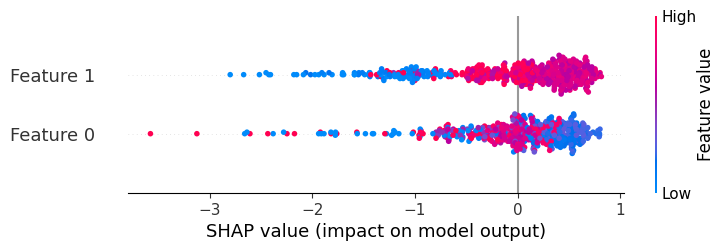

In [29]:
# Explication globale 

explainer_shap = shap.Explainer(forest)
shap_values = explainer_shap(X)
shap.plots.beeswarm(shap_values)

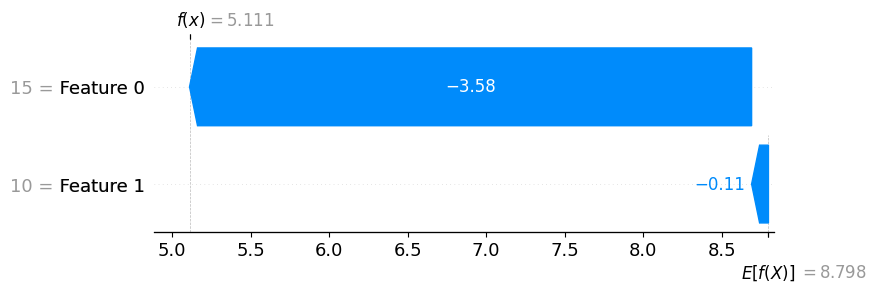

In [33]:
# Explication locale 

shap.plots.waterfall(shap_values[-4])

In [32]:
from shap import initjs

initjs()

shap.plots.force(shap_values[-4:-1])

In [38]:
num_features = 2

liste_shap = []

for i in range(num_features):
    explainer_shap = shap.KernelExplainer(forest,X)
    shap_values = explainer_shap(X, i)
    liste_shap.append(shap_values)
    shap.plots.beeswarm(shap_values)



Provided model function fails when applied to the provided data set.


TypeError: 'IsolationForest' object is not callable